In [1]:
import sys
sys.path.append("..")

# Reload modules in /src/ when changed
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (12, 2)
import seaborn as sns
sns.set(style="ticks", palette="tab10")

In [2]:
from fxml.data.datamodules.multistep_regr_datamodule import MultiStepRegrDataModule
from fxml.models.t2v_transformer_regr.model import T2VTransformerRegressorModule
from fxml.data.normalize_data import denorm

import joblib
from pathlib import Path
from numpy.lib.stride_tricks import sliding_window_view
import torch

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf

# global initialization
with initialize(version_base=None, config_path="../configs", job_name="test_app"):
    exp_cfg = compose(config_name="tune_t2v_xfmr")
    data_cfg = compose(config_name="preprocessing")
    print(OmegaConf.to_yaml(exp_cfg))
    print(OmegaConf.to_yaml(data_cfg))

data:
  train_path: data/processed/USDJPY-15m-20210101-20231231_FEATURES_NORM.pkl
  test_path: data/processed/USDJPY-15m-20240101-20241231_FEATURES_NORM.pkl
  time_features:
  - open
  - high
  - low
  - close
  features:
  - volume
  - close_log_fd_return
  - close_log_return
  - EMA_5
  - EMA_9
  - EMA_20
  - EMA_24
  - EMA_36
  - EMA_50
  - EMA_100
  - EMA_5_slope
  - EMA_9_slope
  - EMA_20_slope
  - EMA_24_slope
  - EMA_36_slope
  - EMA_50_slope
  - EMA_100_slope
  - ATRr_14
  - ATRr_60
  - ATRr_120
  - RSI_14
  target:
  - close
  lookback: 120
  lookforward: 60
model:
  name: t2v_transformer_regr
  kernel_size: 2
  d_model: 128
  nhead: 4
  n_layers: 2
  dim_feedforward: 512
  dropout: 0.2
  pool: cls
  lr: 0.0003
  use_positional_encoding: true
training:
  batch_size: 1024
  num_epochs: 100
  num_workers: 0
  val_split: 0.5
  shuffle: true

data:
  train_data_path: data/processed/USDJPY-15m-20210101-20231231_FEATURES.pkl
  test_data_path: data/processed/USDJPY-15m-20240101-20241

In [4]:
root_dir = Path('..')
data = pd.read_pickle('../data/processed/USDJPY-15m-20240101-20241231_FEATURES.pkl') # original data

# Normalize features

In [5]:
from fxml.data.normalize_data import normalize

In [6]:
scaler_cfg = data_cfg.scaler
norm_df = data.copy()

In [7]:
normalize(
    data=norm_df,
    data_name='USDJPY-15m-20210101-20231231_FEATURES',
    scaler_cfg=scaler_cfg,
    scaler_dir='../data/processed/scalers'
)

,open,high,low,close,volume,spread,tick,close_pct_return,close_return,close_log_return,...,minute_sin,minute_cos,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-15 14:15:00,1.240540,1.243612,1.244728,1.246127,9.257624,0.050528,1831,0.936957,1.017181,0.936052,...,1.000000e+00,2.832769e-16,-0.500000,-0.866025,0.0,1.0,0.101168,-0.994869,5.000000e-01,0.866025
2024-01-15 14:30:00,1.246049,1.244462,1.247110,1.245855,9.061743,0.180396,1484,-0.052666,-0.055539,-0.052312,...,5.665539e-16,-1.000000e+00,-0.500000,-0.866025,0.0,1.0,0.101168,-0.994869,5.000000e-01,0.866025
2024-01-15 14:45:00,1.245947,1.243035,1.246668,1.244018,9.330790,0.377383,1774,-0.314156,-0.339132,-0.313569,...,-1.000000e+00,-1.836970e-16,-0.500000,-0.866025,0.0,1.0,0.101168,-0.994869,5.000000e-01,0.866025
2024-01-15 15:00:00,1.244076,1.242287,1.244728,1.240890,9.495551,0.293627,1989,-0.530266,-0.573404,-0.529516,...,0.000000e+00,1.000000e+00,-0.707107,-0.707107,0.0,1.0,0.101168,-0.994869,5.000000e-01,0.866025
2024-01-15 15:15:00,1.240812,1.236681,1.237512,1.234497,9.083378,0.168321,1393,-1.076421,-1.165249,-1.075387,...,1.000000e+00,2.832769e-16,-0.707107,-0.707107,0.0,1.0,0.101168,-0.994869,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 22:45:00,1.995263,1.990445,1.997607,1.993036,6.343160,11.497347,167,-0.297896,-0.345297,-0.297322,...,-1.000000e+00,-1.836970e-16,-0.500000,0.866025,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000
2024-12-30 23:00:00,1.993427,1.997410,1.996416,2.001911,7.805528,5.061155,815,1.372581,1.602861,1.370936,...,0.000000e+00,1.000000e+00,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000
2024-12-30 23:15:00,2.002098,2.000298,2.006354,2.002354,7.252571,1.774177,420,0.061477,0.073927,0.061715,...,1.000000e+00,2.832769e-16,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000


In [8]:
feat_cols = exp_cfg.data.time_features + exp_cfg.data.features 

In [9]:
features = norm_df[feat_cols].values

In [10]:
closes = data['close'].values
target_windows = sliding_window_view(closes[120:], 60)
target_windows.shape

(23803, 60)

In [11]:
feature_windows = sliding_window_view(features, 120, axis=0).transpose(0,2,1)

In [12]:
feature_windows

array([[[ 1.24053993,  1.24361214,  1.24472763, ...,  0.36748783,
          0.44753086,  0.72566876],
        [ 1.24604861,  1.24446151,  1.24711016, ...,  0.36179737,
          0.44361581,  0.72075067],
        [ 1.2459466 ,  1.24303457,  1.24666769, ...,  0.35246538,
          0.43786858,  0.68676666],
        ...,
        [ 1.33697587,  1.33466446,  1.34108394, ...,  0.54130372,
          0.41622672,  0.69570941],
        [ 1.338098  ,  1.33429073,  1.33989267, ...,  0.52215142,
          0.40729962,  0.68831069],
        [ 1.33762195,  1.33354329,  1.33880352, ...,  0.50460673,
          0.39908996,  0.66102954]],

       [[ 1.24604861,  1.24446151,  1.24711016, ...,  0.36179737,
          0.44361581,  0.72075067],
        [ 1.2459466 ,  1.24303457,  1.24666769, ...,  0.35246538,
          0.43786858,  0.68676666],
        [ 1.24407637,  1.24228712,  1.24472763, ...,  0.34779834,
          0.43441987,  0.63152605],
        ...,
        [ 1.338098  ,  1.33429073,  1.33989267, ...,  

## Predict Sequences

In [13]:
X = torch.tensor(feature_windows[0], dtype=torch.float32)

In [14]:
X = X.unsqueeze(0)
X.shape

torch.Size([1, 120, 25])

In [15]:
model = T2VTransformerRegressorModule.load_from_checkpoint('../lightning_logs/t2v_transformer_regr_USDJPY-15m-20210101-20231231_FEATURES_NORM/version_1/checkpoints/best_checkpoint.ckpt')

In [16]:
model = model.to('cpu')

In [17]:
with torch.no_grad():
    model.eval()
    pred = model(X).numpy().reshape(-1, 1)

pred.shape

(60, 1)

# De-Normalize Prediction

In [18]:
scaler = joblib.load('../data/processed/scalers/USDJPY-15m-20210101-20231231_FEATURES/close_std.pkl')

In [19]:
y_true = target_windows[0]

In [20]:
y_pred = scaler.inverse_transform(pred).squeeze()
y_pred

array([148.27556, 148.09877, 147.93785, 147.95563, 148.02887, 147.92429,
       148.06833, 148.13148, 148.04645, 148.08704, 148.00636, 147.91957,
       148.01582, 148.07147, 148.08551, 148.07542, 148.1054 , 148.0357 ,
       148.1282 , 147.96152, 148.07413, 148.04218, 147.96623, 148.15866,
       148.12897, 147.91373, 148.01688, 148.06052, 148.01843, 147.98439,
       148.26021, 148.01501, 148.04723, 148.0442 , 147.98814, 148.10909,
       147.9843 , 148.20807, 148.18733, 147.89633, 147.97351, 147.96198,
       148.14302, 148.06525, 148.2229 , 148.06395, 148.01308, 148.11047,
       147.94415, 148.0197 , 147.97098, 148.05429, 148.02133, 148.03961,
       148.1631 , 148.02733, 148.24185, 147.96796, 148.03993, 148.01978],
      dtype=float32)

In [21]:
print(y_true)

[147.263  147.223  147.269  147.261  147.2085 147.187  147.184  147.197
 147.176  147.1285 147.1125 147.129  147.1305 147.2395 147.248  147.409
 147.436  147.3455 147.335  147.3415 147.2835 147.2085 147.195  147.1745
 147.21   147.2645 147.259  147.33   147.3685 147.3775 147.3335 147.3405
 147.3475 147.3365 147.353  147.434  147.447  147.648  147.5815 147.7995
 147.856  147.7935 147.7065 147.9035 147.8925 147.9185 147.873  147.7625
 147.7985 147.841  147.8795 147.8645 147.7365 147.677  147.7255 147.605
 147.681  147.713  147.756  147.763 ]


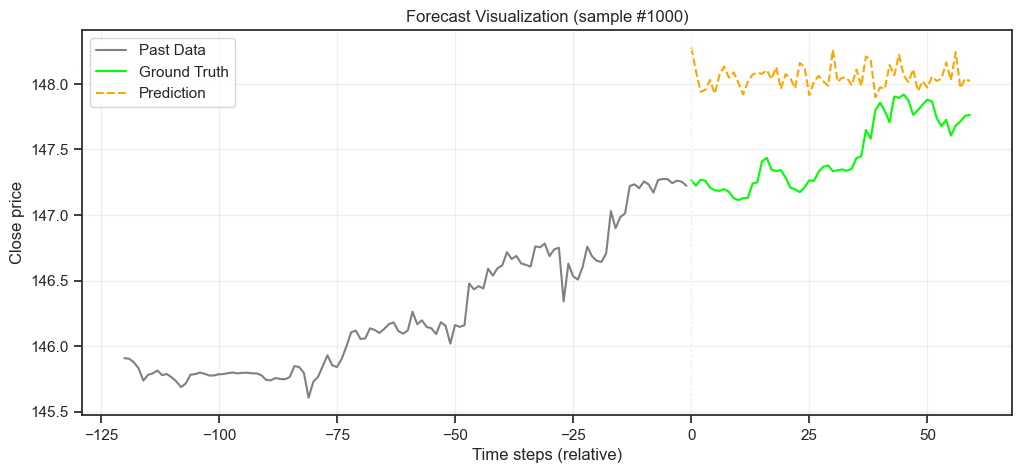

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 假設
lookback = 120
lookforward = 60
idx = 1000  # 要可視化的樣本起點                        # 模型預測（長度同 lookforward）

past = closes[:lookback]
plt.figure(figsize=(12,5))
plt.plot(range(-lookback, 0), past, label="Past Data", color="gray")
plt.plot(range(0, lookforward), y_true, label="Ground Truth", color="lime")
plt.plot(range(0, lookforward), y_pred, label="Prediction", color="orange", linestyle="--")

plt.axvline(0, color="white", linestyle=":")
plt.title(f"Forecast Visualization (sample #{idx})")
plt.xlabel("Time steps (relative)")
plt.ylabel("Close price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
